In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Fetching Dataset

In [2]:
df = pd.read_csv('training_data_2_csv_UTF.csv', encoding='latin1')
acc_df = df.replace(np.nan, '', regex=True)
acc_df.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favorites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokÅ½mon in Houston, TX. See ...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokÅ½ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,,1,349,0,2/1/2016 7:37,38,False,31,en,null,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,,,,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,,11,745,0,1/1/2015 17:44,146,False,185,en,null,False,False,False,lucarivera16,1


# Custom Cleaning Function to clean data

In [3]:
def cleanData(acc_df):
    #Set screen_name = 1 if screen_name contains bot
    acc_df_screen_name = pd.DataFrame(acc_df['screen_name'])
    acc_df_screen_name_lower = acc_df_screen_name['screen_name'].str.lower()
    acc_df['screen_name']=acc_df_screen_name_lower.str.contains('bot')*1
    print('screen_name cleaned')

    #Set location = 1 if location is blank
    acc_df['location']=[(((acc_df.iloc[i]['location']=='')==True)*1) for i in range (len(acc_df))]
    print('location cleaned')
    #acc_df

    # Set description = 1 if it contains words like bot, robot, artificial, intelligence, neural, network,  etc
    words=['bot','robot', 'artificial', 'intelligence', 'neural', 'network','automatic'] #words to be searched in the description
    pat = '|'.join(map(re.escape, words)) #mapping function
    acc_df['description'] = acc_df['description'].str.lower() #converting string to lower case
    acc_df['description']=acc_df.description.str.contains(pat)*1 
    print('description cleaned')
    #acc_df

    #set verified =1 if the account is not verified
    acc_df['verified'] = [((acc_df.iloc[i]['verified']==False) or (acc_df.iloc[i]['verified']=='FALSE'))*1 for i in range (0,len(acc_df))]

    print('verfied cleaned')
    #acc_df['verified']

    #set default_profile =1 if the account has a default_profile
    acc_df['default_profile'] = [(acc_df.iloc[i]['default_profile']==True or acc_df.iloc[i]['default_profile']=="TRUE")*1 for i in range (0,len(acc_df))]
    #acc_df['default_profile'] = [(acc_df.iloc[i]['default_profile']=="TRUE")*1 for i in range (0,len(acc_df))]
    print('default_profile cleaned')
    #acc_df

    #set default_profile_image =1 if the account has a default_profile_image
    acc_df['default_profile_image'] = [(acc_df.iloc[i]['default_profile_image']==True or acc_df.iloc[i]['default_profile_image']=='TRUE')*1 for i in range (0,len(acc_df))]
    print('default_profile_image cleaned')
    #acc_df

    #set has_extended_profile =1 if the account does not have a has_extended_profile
    acc_df['has_extended_profile'] = [(acc_df.iloc[i]['has_extended_profile']==False or acc_df.iloc[i]['has_extended_profile']=='FALSE')*1 for i in range (0,len(acc_df))]
    print('has_extended_profile cleaned')
    #acc_df
    
    #set bot =1 if the account is a bot account
    acc_df['bot'] = [(acc_df.iloc[i]['bot']==True)*1 for i in range (0,len(acc_df))]
    print('bot cleaned')
    #acc_df

    #filling blank rows of dataframe
    header_value = ['followers_count','listedcount','friends_count','favorites_count','statuses_count']
    for header_name in header_value:
        temp = list()
        for i in range(len(acc_df)):
            if acc_df.iloc[i][header_name]=='':
                temp.append(0)
            else:
                temp.append(int(acc_df.iloc[i][header_name]))
        acc_df[header_name]= temp
    #print('Cleaned columns: followers_count, listed_count, friends_count, favorites_count, statuses_count')
    
    #standardize the continuous parameter values
    header_value = ['followers_count','listedcount','friends_count','favorites_count','statuses_count']
    for header_name in header_value:
        temp = list()
        for i in range(len(acc_df)):
            temp.append((acc_df.iloc[i][header_name]-min(acc_df[header_name]))/(max(acc_df[header_name])-min(acc_df[header_name])))
        acc_df[header_name]= temp

    #'favorites_count','followers_count','listedcount'
    acc_df = acc_df.filter(['screen_name','location','description','listedcount','friends_count','followers_count','favorites_count','verified','statuses_count','default_profile','default_profile_image','has_extended_profile','name','bot'], axis=1)
    return acc_df
    

In [4]:
acc_df=cleanData(acc_df) #calling cleaning function
print(acc_df.shape)
acc_df.to_csv('train.csv')
acc_df = acc_df.filter(['friends_count','screen_name','location','description','followers_count','listedcount','bot'], axis=1)
acc_df.head()

screen_name cleaned
location cleaned
description cleaned
verfied cleaned
default_profile cleaned
default_profile_image cleaned
has_extended_profile cleaned
bot cleaned
(2797, 14)


,friends_count,screen_name,location,description,followers_count,listedcount,bot
0,0.000000,0,0,0,1.340302e-05,0.000016,1
1,0.000170,0,0,0,1.038189e-08,0.000000,1
2,0.000000,1,1,1,1.127473e-05,0.000023,1
3,0.000000,0,1,0,3.426024e-07,0.000013,1
4,0.000362,0,0,0,1.142008e-07,0.000000,1


### KNN implementation for neighbors 1-50

Neighbor: 12 
Accuracy: 0.822030651341


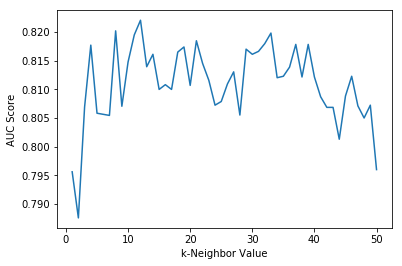

In [5]:
# create design matrix X and target vector y
X = np.array(acc_df.ix[:, 0:len(acc_df.columns)-1])
y = np.array(acc_df['bot'])

# spliting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

neighbor = list(range(1,51))
roc_auc=list()
for i in neighbor:
    knn = KNeighborsClassifier(n_neighbors=i)
    pred = knn.fit(X_train, y_train).predict(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
    roc_auc.append(metrics.auc(fpr, tpr))
    
print('Neighbor:',roc_auc.index(max(roc_auc))+1,'\nAccuracy:',max(roc_auc))
plt.plot(neighbor, roc_auc)
plt.xlabel('k-Neighbor Value')
plt.ylabel('AUC Score')
plt.show()

# Performing 10 Fold CV

In [6]:
neighbor = list(range(1,51))
CV = list(range(1,11))
score=list()
roc_auc = list()
roc_auclist= list()
acclist = list()
X_folds = np.array_split(acc_df.ix[:, 0:len(acc_df.columns)-1], 10)
y_folds = np.array_split(acc_df['bot'],10)

for i in neighbor:
    roc_auc.append(list())
    for k in CV:
        X_train = list(X_folds)
        X_test  = X_train.pop(k-1)
        X_train = np.concatenate(X_train)
        y_train = list(y_folds)
        y_test  = y_train.pop(k-1)
        y_train = np.concatenate(y_train)

        knn = KNeighborsClassifier(n_neighbors=i)
        fit = knn.fit(X_train, y_train)
        pred = fit.predict(X_test)
        score.append(accuracy_score(y_test,pred))
    acclist.append(np.mean(score))

# Plotting Neighbor vs 10-Fold Cross validated Accuracy Score

Maximum accuracy achieved at Neighbor value(k): 7 
Mean Accuracy: 0.798090849243


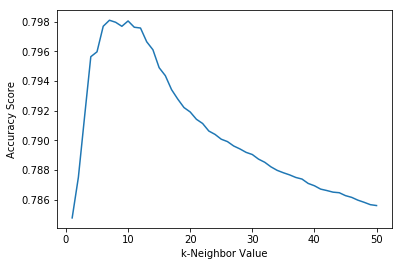

In [7]:
print('Maximum accuracy achieved at Neighbor value(k):',acclist.index(max(acclist))+1,'\nMean Accuracy:',max(acclist))
plt.plot(neighbor, acclist)
plt.xlabel('k-Neighbor Value')
plt.ylabel('Accuracy Score')
plt.show()

# Refitting Model

Mean score after performing 10-fold CV with 7 neighbor is: 0.800522273425


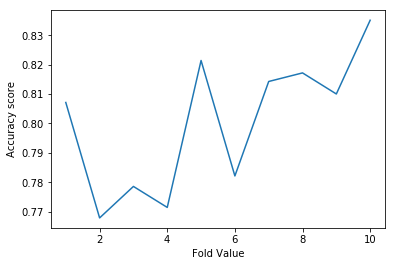

In [8]:
CV = list(range(1,11))
predictionlist = list()
refitscore = list()
X_folds = np.array_split(acc_df.ix[:, 0:len(acc_df.columns)-1], 10)
y_folds = np.array_split(acc_df['bot'],10)

for k in CV:
    X_train = list(X_folds)
    X_test  = X_train.pop(k-1)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k-1)
    y_train = np.concatenate(y_train)

    knn = KNeighborsClassifier(n_neighbors=acclist.index(max(acclist))+1)
    knn1 = knn.fit(X_train, y_train)
    pred = knn1.predict(X_test)
    predictionlist.append(pred)
    refitscore.append(accuracy_score(pred,y_test))

print('Mean score after performing 10-fold CV with',acclist.index(max(acclist))+1,'neighbor is:',np.mean(refitscore))
plt.plot(np.arange(1,11), refitscore)
plt.xlabel('Fold Value')
plt.ylabel('Accuracy score')
plt.show()
#testlist.append(y_test)
#predictionlist
#pred

pred = [item for predictionlist in predictionlist for item in predictionlist]

# Results

Confusion Matrix:
 [[1199  277]
 [ 281 1040]]

Classification report:
              precision    recall  f1-score   support

          0       0.81      0.81      0.81      1476
          1       0.79      0.79      0.79      1321

avg / total       0.80      0.80      0.80      2797



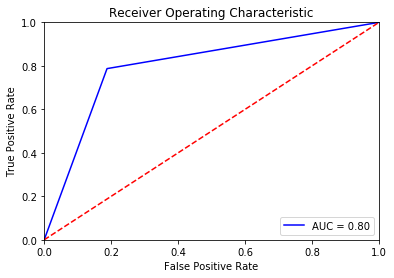

0.79980649257665926

In [9]:
print('Confusion Matrix:\n',confusion_matrix(acc_df['bot'],pred))

print('\nClassification report:\n',classification_report(acc_df['bot'], pred))


fpr, tpr, threshold = metrics.roc_curve(acc_df['bot'], pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc

### Testing


In [10]:
df = pd.read_csv('test_data_4_students.csv', encoding='latin1')
test=df[0:575]
test = test.replace(np.nan, "", regex=True)
test = test.replace('None', "", regex=True)
print(test.shape)
test

(575, 20)


,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favorites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,2.281293e+09,2281292622,__keating,brooklyn,lgbt editor at @buzzfeed. shannon.keating@buzz...,https://t.co/QneJmYRyhj,4466,1295,111,Tue Jan 07 23:26:52 +0000 2014,1579,TRUE,3036,en,{'created_at': 'Tue Apr 11 15:31:51 +0000 2017...,FALSE,FALSE,FALSE,shannon keating,
1,2.344040e+09,2344040251,_callme_Dani,"Los Angeles, CA",News Curation Editor @BuzzFeedNews \rI do a lo...,,295,1016,10,Fri Feb 14 19:45:56 +0000 2014,300,FALSE,618,en,{'created_at': 'Tue Apr 11 00:56:02 +0000 2017...,FALSE,FALSE,FALSE,Danielle Hopkins,
2,7.658713e+08,765871267,_little_britt_,,Family comes first! Also I am in love with piz...,https://t.co/E7DE1cJB7e,1001678,3017,14,8/18/2012 15:13,13040,TRUE,3329,en,"{'place': , 'retweeted': False, 'favorited': F...",TRUE,FALSE,TRUE,Brittney Smith,
3,4.772373e+09,4772373433,134k5,,@BuzzFeedJapan â°Â Â @cnet_japan / DMÅ½ÃÃâ...,https://t.co/Cbguzs2PjT,445,487,17,Sun Jan 17 07:11:45 +0000 2016,1112,FALSE,46,ja,{'created_at': 'Sat Apr 08 08:41:08 +0000 2017...,FALSE,FALSE,TRUE,Keigo Isashi,
4,1.324549e+09,,2181chrom_bot,Ã¨â¡ÂªÃ¥Ëâ Ã£ÂÂ®Ã¥Â¤Â©Ã¥Â¹â¢,Ã£ÂâÃ£âÅÃ£ÂÂ¯FEÃ¨Â¦Å¡Ã©â âÃ£ÂÂ®Ã£â...,http://t.co/10Swf6luED,187,68,13,Wed Apr 03 13:00:42 +0000 2013,,,690359,ja,"{u'lang': u'ja', u'text': u'@2181lucina_bot \u...",,,,Ã£ÆâÃ£âÂ¤Ã¥Â»ÆÃ£âÂ¯Ã£ÆÂ­Ã£ÆÂ bot,
5,2.561342e+09,,2LA1R_bot,,Ã£ÂÂµÃ£âÅÃ£ÂâÃ¨ÂªÅ¾Ã£ââÃ£ÂÂ¤Ã£ÂÂ¶...,,80,87,,Wed Jun 11 13:12:06 +0000 2014,,,20167,ja,"{u'lang': u'ja', u'text': u'\u3010\u3075\u308c...",TRUE,,,Ã£ÂÂµÃ£âÅÃ£ÂâÃ¨ÂªÅ¾bot ver0.2,
6,3.478101e+08,,3pei_bot,Ã¤Â¸â°Ã¦Â²Â³Ã¥Â±â¹,Ã¢âÂ Ã£ÂÂ¡Ã£âÂÃ£ÆÂ¼Ã£Ââ¢Ã¯Â¼ÂÃ¤Â¸â°...,http://twpf.jp/3pei_bot,2020,1978,56,Wed Aug 03 11:52:59 +0000 2011,,,968182,ja,"{u'lang': u'ja', u'text': u'@kazenoraby \uff66...",TRUE,,,Ã¤Â¸â°Ã¦Â²Â³Ã¥Â±â¹Ã¤Â¸â°Ã¥Â¹Â³,
7,8.563039e+08,,94kichi_bot,,94 Ã£ÆÂÃ£ÆÂ£Ã£ÆÆÃ£âÂ¯Ã£ÆÂ»Ã£âÂ¦Ã£â...,,70,80,2,Mon Oct 01 12:39:46 +0000 2012,,,76735,ja,"{u'lang': u'ja', u'text': u'\u307f\u3093\u306a...",TRUE,,,94Ã¥Â¹Â´Ã§Âµâbot,
8,8.328750e+17,,A3_Dekasegi_bot,Ã£ÆâÃ£ÆÂ­Ã£ÆÂ¼Ã£Æâ°Ã©Â§â¦Ã¥â°Â,Ã£âÂ·Ã£ÆËÃ£ÆÂ­Ã£ÆÂ³Ã£â¬ÅA3!Ã¥â¡ÂºÃ§Â¨...,https://t.co/t171JmIrjL,181,144,2,Sat Feb 18 08:50:03 +0000 2017,,,1960,ja,"{u'lang': u'ja', u'text': u'\u30b7\u30c8\u30ed...",TRUE,,,A3! Ã¥â¡ÂºÃ§Â¨Â¼Ã£ÂÅ½Ã¦âÂ¥Ã¨ÂªÅ,
9,8.885679e+07,,aamir_khan,Mumbai,Actor.,https://t.co/l1dUhQjS8Y,20419393,9,6,Tue Nov 10 05:08:56 +0000 2009,,TRUE,468,en,"{u'lang': u'en', u'text': u'Hey guys, doing so...",,,,Aamir Khan,


### Cleaned Testdata

In [11]:
cleanedTest = cleanData(test)
print(cleanedTest.shape)
cleanedTest.to_csv('test.csv')
cleanedTest

cleanedTest = cleanedTest.filter(['friends_count','screen_name','location','description','followers_count','listedcount'], axis=1)
cleanedTest.head()

screen_name cleaned
location cleaned
description cleaned
verfied cleaned
default_profile cleaned
default_profile_image cleaned
has_extended_profile cleaned
bot cleaned
(575, 14)


,friends_count,screen_name,location,description,followers_count,listedcount
0,0.002054,0,0,0,0.000046,0.000179
1,0.001611,0,0,0,0.000003,0.000016
2,0.004785,0,1,0,0.010335,0.000023
3,0.000772,0,1,0,0.000005,0.000027
4,0.000108,1,0,1,0.000002,0.000021


### Performing Cross validation

In [12]:
CV = list(range(1,11))
predictionlist = list()
refitscore = list()
X_folds = np.array_split(cleanedTest.ix[:, 0:len(cleanedTest.columns)], 10)

for k in CV:
    X_train = list(X_folds)
    X_test  = X_train.pop(k-1)
    X_train = np.concatenate(X_train)
    
    pred = knn1.predict(X_test)
    predictionlist.append(pred)
predictionlist = [item for predictionlist in predictionlist for item in predictionlist]
print(predictionlist)

[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

### Prediction file generation

In [15]:
def submission(pred):
    test['bot'] = pred
    sub = test.filter(['id','bot'], axis=1)
    sub.columns = ['Id','Bot']
    sub.to_csv('sub7.csv',index = False)
    #print(sub)

submission(predictionlist)